# Extract data from dbSNP

Utilize the [Bio.Entrez package](https://biopython.org/docs/latest/api/Bio.Entrez.html) to get data from [dbSNP](https://www.ncbi.nlm.nih.gov/snp/).

## Setup
### Import packages

In [2]:
from Bio import Entrez
import pandas as pd
import numpy as np
from collections import defaultdict
from xml.etree import ElementTree

from rbc_gem_utils import (
    ROOT_PATH,
    DATABASE_PATH,
    GEM_NAME,
    read_rbc_model,
    build_string,
    split_string,
    get_annotation_df,
    show_versions,
)
from rbc_gem_utils.util import has_value_type, explode_column

show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM model

In [3]:
model = read_rbc_model(filetype="xml")
model

Name,RBC_GEM
Memory address,14c89d810
Number of metabolites,1967
Number of reactions,2790
Number of genes,653
Number of groups,74
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [4]:
annotation_type = "genes"
df_model_mappings = get_annotation_df(
    getattr(model, annotation_type), ["dbsnp"]
).rename({"id": annotation_type}, axis=1)
for col in df_model_mappings.columns:
    df = (
        df_model_mappings[col]
        .apply(lambda x: split_string(x))
        .explode(col)
        .drop_duplicates()
    )
    print(f"{df.name}: {df.nunique()}")

df_model_mappings

genes: 653
dbsnp: 4129


,genes,dbsnp
0,RPE,NaN
1,RPIA,rs121918591
2,SORD,rs145813597;rs1042079;rs930337;rs149975952
3,AKR7A2,rs6670759;rs1043657;rs859208;rs859210;rs223120...
4,SRM,rs1049932
...,...,...
648,SCD,rs2234970
649,RPS6KA4,rs746466314;rs17857342
650,GCNT2,rs137853339;rs137853340;rs56141211;rs55940927
651,GRIA1,rs142859488;rs13166146;rs13166161;rs13166438;r...


### Get IDs for query from model

In [5]:
df_model_snps = df_model_mappings.loc[:, ["genes", "dbsnp"]].copy()
df_model_snps["dbsnp"] = df_model_mappings["dbsnp"].apply(split_string)
df_model_snps = df_model_snps.explode("dbsnp")
df_model_snps = df_model_snps.dropna().drop_duplicates()
rs_ids = df_model_snps["dbsnp"].unique()
df_model_snps

,genes,dbsnp
1,RPIA,rs121918591
2,SORD,rs145813597
2,SORD,rs1042079
2,SORD,rs930337
2,SORD,rs149975952
...,...,...
652,A4GALT,rs28915383
652,A4GALT,rs74315453
652,A4GALT,rs28940572
652,A4GALT,rs397514502


In [6]:
def fetch_results_dbSNP(email, rs_ids):
    Entrez.email = email
    search = Entrez.efetch(db="snp", retmode="text", id=rs_ids)
    all_lines = search.readlines()
    search.close()
    return all_lines

### Get results from SNP as a DataFrame

In [7]:
overwrite = True
email = "zhaiman@ucsd.edu"

In [8]:
data = defaultdict(dict)
batch_size = 500
for batch_idx, batch in enumerate(np.arange(0, len(rs_ids), batch_size), start=0):
    query_ids = rs_ids[batch : batch + batch_size]
    print(
        f"Fetching results for batch {batch_idx + 1}  ({batch + len(query_ids)}/{len(rs_ids)})"
    )
    all_lines = fetch_results_dbSNP(email=email, rs_ids=query_ids)
    for entry_idx, xml_str in enumerate(all_lines, start=batch_idx * batch_size):
        entry = ElementTree.fromstring(xml_str)
        data[rs_ids[entry_idx]].update(
            {e.tag: e.text for e in entry if has_value_type(e)}
        )

# Make into DataFrame
df_snps_all = pd.DataFrame.from_dict(data, orient="index")
failed_ids = list(df_snps_all["error"].dropna().index)
print(f"\nNumber of failed IDs: {len(failed_ids)}")
df_snps_all.index.name = "dbsnp"
df_snps_all = df_snps_all[~df_snps_all["error"].notna()]
df_snps_all

Fetching results for batch 1  (500/4129)
Fetching results for batch 2  (1000/4129)
Fetching results for batch 3  (1500/4129)
Fetching results for batch 4  (2000/4129)
Fetching results for batch 5  (2500/4129)
Fetching results for batch 6  (3000/4129)
Fetching results for batch 7  (3500/4129)
Fetching results for batch 8  (4000/4129)
Fetching results for batch 9  (4129/4129)

Number of failed IDs: 2


,SNP_ID,GLOBAL_SAMPLESIZE,CLINICAL_SIGNIFICANCE,ACC,CHR,HANDLE,SPDI,FXN_CLASS,VALIDATED,DOCSUM,...,SS,ALLELE,SNP_CLASS,CHRPOS,CHRPOS_PREV_ASSM,SNP_ID_SORT,CLINICAL_SORT,CHRPOS_SORT,MERGED_SORT,error
dbsnp,,,,,,,,,,,,,,,,,,,,,
rs121918591,121918591,0,pathogenic,NC_000002.12,2,"TOPMED,ILLUMINA,PAGE_CC,OMIM-CURATED-RECORDS,G...",NC_000002.12:88729278:C:T,"coding_sequence_variant,missense_variant","by-frequency,by-alfa,by-cluster","HGVS=NC_000002.12:g.88729279C>T,NC_000002.11:g...",...,"275518424,1958438289,2732810607,3021993357,365...",Y,snv,2:88729279,2:89028797,0121918591,1,0088729279,0,NaN
rs145813597,145813597,0,pathogenic-likely-pathogenic,NC_000015.10,15,"AFFY,TOPMED,EVA_EXAC,HUGCELL_USP,ILLUMINA,1000...","NC_000015.10:45065302:C:A,NC_000015.10:4506530...","non_coding_transcript_variant,missense_variant...","by-frequency,by-alfa,by-cluster","HGVS=NC_000015.10:g.45065303C>A,NC_000015.10:g...",...,"342402496,464140601,491493966,491700043,991737...",H,snv,15:45065303,15:45357501,0145813597,1,0045065303,0,NaN
rs1042079,1042079,0,benign,NC_000015.10,15,"EVA-GONL,CNG,BUSHMAN,SSMP,1000GENOMES,EXOME_CH...","NC_000015.10:45068981:A:G,NC_000015.10:4506898...","coding_sequence_variant,non_coding_transcript_...","by-frequency,by-alfa,by-cluster","HGVS=NC_000015.10:g.45068982A>G,NC_000015.10:g...",...,"1509008,4403349,76874733,95213358,156480828,15...",D,snv,15:45068982,15:45361180,0001042079,1,0045068982,0,NaN
rs930337,930337,0,benign,NC_000015.10,15,"ENSEMBL,CNG,SYSTEMSBIOZJU,SSMP,1000GENOMES,EXO...",NC_000015.10:45072335:A:C,"coding_sequence_variant,non_coding_transcript_...","by-frequency,by-alfa,by-cluster","HGVS=NC_000015.10:g.45072336A>C,NC_000015.9:g....",...,"1368774,2558685,3214527,5252928,21245444,24802...",M,snv,15:45072336,15:45364534,0000930337,1,0045072336,0,NaN
rs149975952,149975952,0,benign,NC_000015.10,15,"ILLUMINA,WEILL_CORNELL_DGM,1000GENOMES,EXOME_C...","NC_000015.10:45073419:G:A,NC_000015.10:4507341...","coding_sequence_variant,missense_variant,non_c...","by-frequency,by-alfa,by-cluster","HGVS=NC_000015.10:g.45073420G>A,NC_000015.10:g...",...,"342402507,489048604,491493972,1353273008,16918...",D,snv,15:45073420,15:45365618,0149975952,1,0045073420,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs28915383,28915383,0,benign,NC_000022.11,22,"SANFORD_IMAGENETICS,HUGCELL_USP,PGA-UW-FHCRC,E...",NC_000022.11:42693463:T:C,"genic_downstream_transcript_variant,coding_seq...","by-frequency,by-alfa,by-cluster","HGVS=NC_000022.11:g.42693464T>C,NC_000022.10:g...",...,"35529216,160596039,173525433,204101017,2287004...",Y,snv,22:42693464,22:43089470,0028915383,1,0042693464,0,NaN
rs74315453,74315453,0,affects,NC_000022.11,22,"ILLUMINA,GNOMAD,OMICIA,PAGE_CC,EVA_EXAC,OMIM-C...",NC_000022.11:42693403:A:T,"genic_downstream_transcript_variant,coding_seq...","by-frequency,by-cluster","HGVS=NC_000022.11:g.42693404A>T,NC_000022.10:g...",...,"179320298,254223349,1694384290,1959984485,2745...",W,snv,22:42693404,22:43089410,0074315453,1,0042693404,0,NaN
rs28940572,28940572,0,"affects,likely-pathogenic",NC_000022.11,22,"ILLUMINA,GNOMAD,EVA_EXAC,OMICIA,OMIM-CURATED-R...",NC_000022.11:42693391:C:T,"genic_downstream_transcript_variant,coding_seq...","by-frequency,by-alfa,by-cluster","HGVS=NC_000022.11:g.42693392C>T,NC_000022.10:g...",...,"169697184,254223366,1694384286,2745199187,3725...",Y,snv,22:42693392,22:43089398,0028940572,1,0042693392,0,NaN


In [9]:
failed_ids

['rs796051928', 'rs1057516483']

### Parse and reformat results

In [10]:
df_model_snps = df_model_mappings.loc[:, ["genes", "dbsnp"]].copy()
df_model_snps["dbsnp"] = df_model_mappings["dbsnp"].apply(split_string)
df_model_snps = df_model_snps.explode("dbsnp")
df_model_snps = df_model_snps.dropna().drop_duplicates()
rs_ids = df_model_snps["dbsnp"].unique()
df_model_snps

rename_mapping = {
    key: key.lower()
    for key in df_snps_all.columns
    if key not in {"error", "GLOBAL_SAMPLESIZE"}
}

df_model_snps = df_model_snps.merge(
    df_snps_all.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1),
    left_on="dbsnp",
    right_on="dbsnp",
    how="inner",
)
for col in df_model_snps.columns:
    df_model_snps[col] = df_model_snps[col].str.split(",")
    # Switch to default seperator (currently semicolon)
    df_model_snps[col] = df_model_snps[col].apply(lambda x: build_string(x))
df_model_snps = df_model_snps.sort_values(["snp_id_sort"]).reset_index(drop=True)
df_model_snps["sequence_change"] = (
    df_model_snps["spdi"]
    .dropna()
    .apply(lambda value: [s.split(":", 2)[-1] for s in split_string(value)])
)
df_model_snps

,genes,dbsnp,snp_id,clinical_significance,acc,chr,handle,spdi,fxn_class,validated,...,ss,allele,snp_class,chrpos,chrpos_prev_assm,snp_id_sort,clinical_sort,chrpos_sort,merged_sort,sequence_change
0,HBB,rs334,334,protective;other;pathogenic;benign;likely-beni...,NC_000011.10,11,JMKIDD_LAB;FSA-LAB;MILLER_NIDDK;KHV_HUMAN_GENO...,NC_000011.10:5227001:T:A;NC_000011.10:5227001:...,missense_variant;coding_sequence_variant,by-frequency;by-alfa;by-cluster,...,335;24811263;48419811;49850538;49850540;498505...,N,snv,11:5227002,11:5248232,0000000334,1,0005227002,0,"[T:A, T:C, T:G]"
1,GSTP1,rs1695,1695,benign;not-provided,NC_000011.10,11,CSHL;BCM-HGSC-SUB;1000GENOMES;EVA_SVP;MGC_GENO...,NC_000011.10:67585217:A:G;NC_000011.10:6758521...,missense_variant;coding_sequence_variant,by-frequency;by-alfa;by-cluster,...,1720;5330;9110;1390210;1545478;3178003;5586573...,D,snv,11:67585218,11:67352689,0000001695,1,0067585218,0,"[A:G, A:T]"
2,FKBP2,rs4672,4672,NaN,NC_000011.10,11,JMKIDD_LAB;FSA-LAB;KHV_HUMAN_GENOMES;CLINSEQ_S...,NC_000011.10:64242406:G:A;NC_000011.10:6424240...,3_prime_UTR_variant;intron_variant;missense_va...,by-frequency;by-alfa;by-cluster,...,1555019;4436250;20825221;24790172;39886556;752...,D,snv,11:64242407,11:64009879,0000004672,0,0064242407,0,"[G:A, G:T]"
3,COMT,rs4680,4680,drug-response;benign,NC_000022.11,22,GRF;YSAMUELS;EVA_SAMSUNG_MC;MGC_GENOME_DIFF;AB...,NC_000022.11:19963747:G:A,2KB_upstream_variant;coding_sequence_variant;u...,by-frequency;by-alfa;by-cluster,...,5363;10902;232568;458935;593353;869771;1058120...,R,snv,22:19963748,22:19951271,0000004680,1,0019963748,0,[G:A]
4,GLO1,rs4746,4746,uncertain-significance,NC_000006.12,6,ACPOP;TRAN_CS_UWATERLOO;TISHKOFF;SI_EXO;EVA_UK...,NC_000006.12:38682851:T:A;NC_000006.12:3868285...,coding_sequence_variant;missense_variant,by-frequency;by-alfa;by-cluster,...,3863270;20275576;24369377;28505662;44730940;48...,D,snv,6:38682852,6:38650628,0000004746,1,0038682852,0,"[T:A, T:G]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4122,VPS4A,rs1965499910,1965499910,pathogenic,NC_000016.10,16,None,NC_000016.10:69320767:A:G;NC_000016.10:6932076...,missense_variant;coding_sequence_variant,NaN,...,0,D,snv,16:69320768,16:69354671,1965499910,1,0069320768,0,"[A:G, A:T]"
4123,FARSA,rs1971301248,1971301248,pathogenic,NC_000019.10,19,None,NC_000019.10:12924491:G:T,coding_sequence_variant;missense_variant,NaN,...,0,K,snv,19:12924492,19:13035306,1971301248,1,0012924492,0,[G:T]
4124,CNP,rs2050933471,2050933471,pathogenic,NC_000017.11,17,None,NC_000017.11:41968308:C:T,coding_sequence_variant;missense_variant,NaN,...,0,Y,snv,17:41968309,17:40120327,2050933471,1,0041968309,0,[C:T]
4125,PISD,rs2072505076,2072505076,pathogenic-likely-pathogenic,NC_000022.11,22,None,NC_000022.11:31620658:C:T,coding_sequence_variant;intron_variant;missens...,NaN,...,0,Y,snv,22:31620659,22:32016645,2072505076,1,0031620659,0,[C:T]


### Export data

In [11]:
if overwrite:
    df_model_snps.to_csv(f"{ROOT_PATH}{DATABASE_PATH}/snps_{GEM_NAME}.tsv", sep="\t")
else:
    df_model_snps.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/snps_{GEM_NAME}.tsv", sep="\t")
df_model_snps

,genes,dbsnp,snp_id,clinical_significance,acc,chr,handle,spdi,fxn_class,validated,...,ss,allele,snp_class,chrpos,chrpos_prev_assm,snp_id_sort,clinical_sort,chrpos_sort,merged_sort,sequence_change
0,HBB,rs334,334,protective;other;pathogenic;benign;likely-beni...,NC_000011.10,11,JMKIDD_LAB;FSA-LAB;MILLER_NIDDK;KHV_HUMAN_GENO...,NC_000011.10:5227001:T:A;NC_000011.10:5227001:...,missense_variant;coding_sequence_variant,by-frequency;by-alfa;by-cluster,...,335;24811263;48419811;49850538;49850540;498505...,N,snv,11:5227002,11:5248232,0000000334,1,0005227002,0,"[T:A, T:C, T:G]"
1,GSTP1,rs1695,1695,benign;not-provided,NC_000011.10,11,CSHL;BCM-HGSC-SUB;1000GENOMES;EVA_SVP;MGC_GENO...,NC_000011.10:67585217:A:G;NC_000011.10:6758521...,missense_variant;coding_sequence_variant,by-frequency;by-alfa;by-cluster,...,1720;5330;9110;1390210;1545478;3178003;5586573...,D,snv,11:67585218,11:67352689,0000001695,1,0067585218,0,"[A:G, A:T]"
2,FKBP2,rs4672,4672,NaN,NC_000011.10,11,JMKIDD_LAB;FSA-LAB;KHV_HUMAN_GENOMES;CLINSEQ_S...,NC_000011.10:64242406:G:A;NC_000011.10:6424240...,3_prime_UTR_variant;intron_variant;missense_va...,by-frequency;by-alfa;by-cluster,...,1555019;4436250;20825221;24790172;39886556;752...,D,snv,11:64242407,11:64009879,0000004672,0,0064242407,0,"[G:A, G:T]"
3,COMT,rs4680,4680,drug-response;benign,NC_000022.11,22,GRF;YSAMUELS;EVA_SAMSUNG_MC;MGC_GENOME_DIFF;AB...,NC_000022.11:19963747:G:A,2KB_upstream_variant;coding_sequence_variant;u...,by-frequency;by-alfa;by-cluster,...,5363;10902;232568;458935;593353;869771;1058120...,R,snv,22:19963748,22:19951271,0000004680,1,0019963748,0,[G:A]
4,GLO1,rs4746,4746,uncertain-significance,NC_000006.12,6,ACPOP;TRAN_CS_UWATERLOO;TISHKOFF;SI_EXO;EVA_UK...,NC_000006.12:38682851:T:A;NC_000006.12:3868285...,coding_sequence_variant;missense_variant,by-frequency;by-alfa;by-cluster,...,3863270;20275576;24369377;28505662;44730940;48...,D,snv,6:38682852,6:38650628,0000004746,1,0038682852,0,"[T:A, T:G]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4122,VPS4A,rs1965499910,1965499910,pathogenic,NC_000016.10,16,None,NC_000016.10:69320767:A:G;NC_000016.10:6932076...,missense_variant;coding_sequence_variant,NaN,...,0,D,snv,16:69320768,16:69354671,1965499910,1,0069320768,0,"[A:G, A:T]"
4123,FARSA,rs1971301248,1971301248,pathogenic,NC_000019.10,19,None,NC_000019.10:12924491:G:T,coding_sequence_variant;missense_variant,NaN,...,0,K,snv,19:12924492,19:13035306,1971301248,1,0012924492,0,[G:T]
4124,CNP,rs2050933471,2050933471,pathogenic,NC_000017.11,17,None,NC_000017.11:41968308:C:T,coding_sequence_variant;missense_variant,NaN,...,0,Y,snv,17:41968309,17:40120327,2050933471,1,0041968309,0,[C:T]
4125,PISD,rs2072505076,2072505076,pathogenic-likely-pathogenic,NC_000022.11,22,None,NC_000022.11:31620658:C:T,coding_sequence_variant;intron_variant;missens...,NaN,...,0,Y,snv,22:31620659,22:32016645,2072505076,1,0031620659,0,[C:T]


### Visualize genetic landscape

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

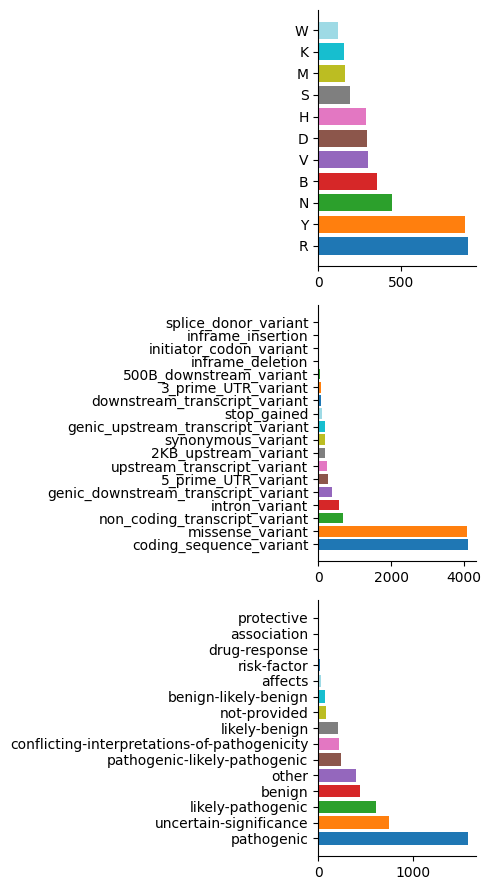

In [20]:
df_snps_per_gene = (
    df_model_snps.groupby("genes")["dbsnp"]
    .agg(lambda x: x.nunique())
    .sort_values(ascending=False)
)
df_snp_fxn_class = (
    df_model_snps["fxn_class"].apply(split_string).explode().value_counts()
)
df_snp_clinical_significance = (
    df_model_snps["clinical_significance"].apply(split_string).explode().value_counts()
)
df_snp_allele = df_model_snps["allele"].apply(split_string).explode().value_counts()

fig, axes = plt.subplots(3, 1, figsize=(5, 9))
(ax_allele, ax_fxn_class, ax_clinical_significance) = axes.flatten()
sns.despine(fig)
cmin = 0
cmax = 1
colors = mpl.colormaps["tab20"](np.linspace(cmin, cmax, len(df_snp_allele.index)))

ax_allele.barh(
    df_snp_allele.index,
    df_snp_allele.values,
    color=colors,
)
ax_fxn_class.barh(
    df_snp_fxn_class.index,
    df_snp_fxn_class.values,
    color=colors,
)
ax_clinical_significance.barh(
    df_snp_clinical_significance.index,
    df_snp_clinical_significance.values,
    color=colors,
)
fig.tight_layout()